Derivation of the mean SED of type-1 QSOs as done in Krawczyk+2013.

In [30]:
import os
import time
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
from my_functions import library as lb
from my_functions import corrections 
from my_functions import interpolation_processes as ip


pd.options.mode.chained_assignment = None  # default='warn'

In [31]:
def dictionary_4_columns(old_magnitudes_names, old_error_names, new_magnitudes_names):
    assert(len(old_magnitudes_names)==len(old_error_names))
    assert(len(old_magnitudes_names)==len(new_magnitudes_names))
    new_error_names =[f"err_{i}" for i in new_magnitudes_names]
    dictionary = dict()
    for omn, oen, nmn, nen in zip(old_magnitudes_names, old_error_names,
                                  new_magnitudes_names, new_error_names):
        dictionary.update({omn:nmn, oen:nen})
    return dictionary


## Settings

In [3]:
#data available here: https://vizier.cds.unistra.fr/viz-bin/VizieR-3?-source=J/ApJS/206/4/qsos
magnitudes_filename = 'krawczyk_magnitudes.csv' 


rapid_corrections = True
z_min, z_max, delta_z = 0, 7, 0.01
DLA = False
H0 = 70
Om0 = 0.3
grid = np.arange(np.log10(912), 4.75, 0.02)
bands_to_merge = [("UKIDSS.J", "2MASS.J"),("UKIDSS.H", "2MASS.H" ), ("UKIDSS.K", "2MASS.K")] ##list of lists of bands to merge
merged_new_names = ["J", "H", "K" ]  

## Table cleaning 

In [4]:
extra_features_names = ['Name', 'RAJ2000', 'DEJ2000', 'z', 'd_g-i_', 'logL250', 'e_logL250',
       'logL510', 'e_logL510', 'BC', 'e_BC', 'logIR', 'e_logIR', 'logOX',
       'e_logOX', 'logSX', 'e_logSX', 'logHX', 'e_logHX', 'recno']

filter_df = pd.read_csv("input_filtri.dat", comment = '#', delim_whitespace = True)

filter_names = filter_df["Name"].to_list()
to_correct = filter_df["apply_corrections"].to_list()

filters = [lb.filtro(i) for i in filter_names]
data = pd.read_table(magnitudes_filename, delimiter =',',header=0)
if 'd_g-i_' in data.columns:
    data = data[data['d_g-i_']<=0.3]    #Removing Red QSOs
    print("Removing red QSOs")
else:
    print("Keeping red QSOs")

Removing red QSOs


In [5]:
magnitudes_columns = [i for i in data.columns if i not in extra_features_names]
magnitudes_df = data[magnitudes_columns]
redshift = data["z"].to_numpy()
old_error_names = [i for i in magnitudes_columns if "e_" in i]
old_magnitudes_names = [i for i in magnitudes_columns if "e_" not in i]
dictionary = dictionary_4_columns(old_magnitudes_names, old_error_names, filter_names)
magnitudes_df.rename(columns = dictionary, inplace = True)
magnitudes_df.replace(to_replace = 0, value = np.nan, inplace = True)
magnitudes_df.replace(to_replace = -99, value = np.nan, inplace = True)
magnitudes_df.replace(to_replace = +99, value = np.nan, inplace = True)

magnitudes = lb.two_2_three(magnitudes_df, has_wavelength = False)


## Corrections for IGM and Emission Lines

In [6]:
#Correcting magnitudes
tic =  time.perf_counter()
if rapid_corrections:
    rapid_z = np.arange(z_min,z_max+delta_z, step = delta_z, dtype ='float')
    delta_magnitudes = np.zeros((magnitudes.shape[1], len(rapid_z)))
    for i, filtro in enumerate(filters):
        if to_correct[i]:
            delta_magnitudes[i,:] = corrections.correct_magnitudes(rapid_z, filtro, DLA = DLA)
            print(f"Corrected magnitudes for {filtro.name}")
    for i, z in enumerate(redshift):
        magnitudes[i,:,0] -= delta_magnitudes[:, round((z-z_min)/delta_z)]
else:
    for i, filtro in enumerate(filters):
        if to_correct[i]:
            magnitudes[:,i,0]-=corrections.correct_magnitudes(redshift, filtro, DLA = DLA)
            print(f"Corrected magnitudes for {filtro.name}")
toc = time.perf_counter()
print(f"Corrections  required {toc-tic:0.4f} seconds.\n")

Corrected magnitudes for SLOAN_SDSS.u
Corrected magnitudes for SLOAN_SDSS.g
Corrected magnitudes for SLOAN_SDSS.r
Corrected magnitudes for SLOAN_SDSS.i
Corrected magnitudes for SLOAN_SDSS.z
Corrected magnitudes for 2MASS_2MASS.J
Corrected magnitudes for 2MASS_2MASS.H
Corrected magnitudes for 2MASS_2MASS.Ks
Corrected magnitudes for GALEX_GALEX.FUV
Corrected magnitudes for GALEX_GALEX.NUV
Corrected magnitudes for Spitzer_IRAC.I1
Corrected magnitudes for Spitzer_IRAC.I2
Corrected magnitudes for UKIRT_UKIDSS.Y
Corrected magnitudes for UKIRT_UKIDSS.J
Corrected magnitudes for UKIRT_UKIDSS.H
Corrected magnitudes for UKIRT_UKIDSS.K
Corrected magnitudes for WISE_WISE.W1
Corrected magnitudes for WISE_WISE.W2
Corrections  required 22.8923 seconds.



## Merging bands

In [7]:
temp_magnitudes = np.zeros((magnitudes.shape[0],magnitudes.shape[1], 3))
temp_magnitudes[:,:, 0] = np.array([i.wav for i in filters])
temp_magnitudes[:,:,1:] = magnitudes
magnitudes_df = lb.three_2_two(temp_magnitudes, band_names = filter_names)
del temp_magnitudes

In [8]:
for new_name, bands in zip(merged_new_names, bands_to_merge):
    magnitudes_df[f"lambda_{new_name}"], magnitudes_df[new_name], magnitudes_df[f"err_{new_name}"] = \
                           lb.merge_bands_complete(magnitudes_df, bands)
    for filtro in bands:
        magnitudes_df.drop(columns = [f"lambda_{filtro}", filtro, f"err_{filtro}"], inplace = True)

## Gap filling

In [9]:
magnitudes = lb.two_2_three(magnitudes_df)
magnitudes = magnitudes[:,np.argsort(magnitudes[0,:,0]), :]
magnitudes, coefficients = corrections.process_errors(magnitudes, minimum_error = 0.0, shift_errors = False)
magnitudes = corrections.gap_filling(magnitudes, redshift, coefficients)

Using mean SED by Krawczyk+13 to perform gap repair


## Removing Host luminosity

In [10]:
luminosity = lb.get_luminosity(magnitudes, redshift, H0 = H0, Om0 = Om0)
L_host, wrongly_estimated  = corrections.host_correction(luminosity, control_negative = True)
print(f"Warning {np.sum(wrongly_estimated)} QSOs have L_host > L_all, L_host set to 0")
luminosity = luminosity - L_host

Warning 1 QSOs have L_host > L_all, L_host set to 0


In [11]:
#take_log
luminosity[:,:,0] = np.log10(luminosity[:,:,0])
luminosity[:,:,2] = luminosity[:,:,2]/(luminosity[:,:,1]*np.log(10))
luminosity[:,:,1] = np.log10(luminosity[:,:,1])

## Interpolate over grid

In [24]:
interpolated_data = np.empty((luminosity.shape[0], len(grid), 3))
interpolated_data.fill(np.nan)
tic = time.perf_counter()
for j in range(luminosity.shape[0]):
     #interpolated_data[j,:,:]= ip.get_GPR(luminosity[j,:,:], grid)
     interpolated_data[j,:,:]= ip.get_linear_interpolation(luminosity[j,:,:], grid, extrapolate = True)
     if j%10000 ==0:
        print(f'Interpolated {j}th QSO')

toc = time.perf_counter()
print(f"Kriging reguired {toc-tic:0.1f} seconds")


Interpolated 0th QSO
Interpolated 10000th QSO
Interpolated 20000th QSO
Interpolated 30000th QSO
Interpolated 40000th QSO
Interpolated 50000th QSO
Interpolated 60000th QSO
Interpolated 70000th QSO
Interpolated 80000th QSO
Interpolated 90000th QSO
Interpolated 100000th QSO
Kriging reguired 10.8 seconds


In [28]:
mean_sed = np.zeros((interpolated_data.shape[1], interpolated_data.shape[2]))
mean_sed[:,0] = interpolated_data[0,:,0]   ###wavelength

###Take mean/median/ weighted mean
for i in range(mean_sed.shape[0]):
    mean_sed[i,1] = np.nanmedian(interpolated_data[:, i, 1])
    mean_sed[i,2] = np.nanstd(interpolated_data[:,i,1])

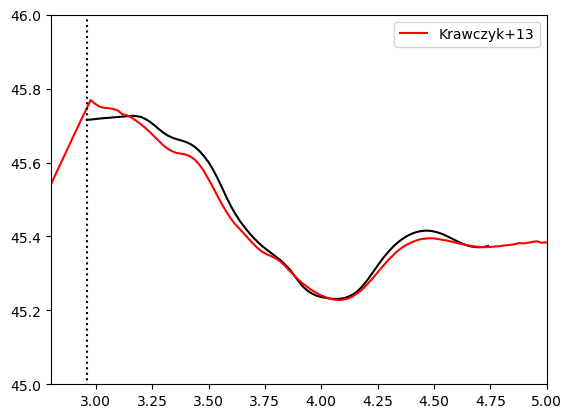

In [29]:
kra13 = lb.get_sed(which_sed ='krawczyk')
fig, ax = plt.subplots()
ax.plot(mean_sed[:,0], mean_sed[:,1], c='k')
ax.plot(np.log10(kra13 [:,0]), np.log10(kra13 [:,1]), c='r', label ="Krawczyk+13")
ax.plot([np.log10(912),np.log10(912)], [42, 48], c ='k', ls =':')
ax.set_xlim(2.8, 5)
ax.set_ylim(45,  46)
ax.legend()

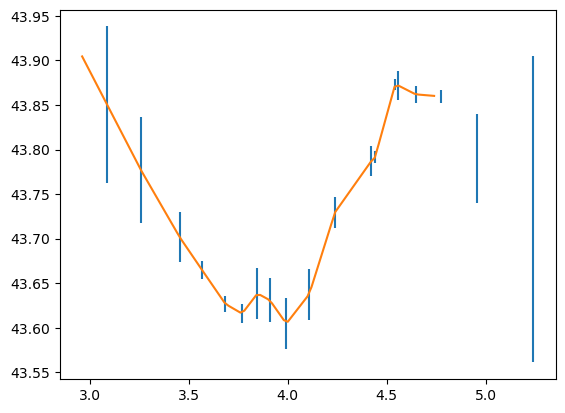

In [27]:
idx = 90
fig, ax = plt.subplots()
ax.errorbar(luminosity[idx,:, 0], luminosity[idx,:, 1], luminosity[idx,:, 2], ls = 'none')
ax.plot(interpolated_data[idx,:, 0], interpolated_data[idx,:, 1])

In [25]:
luminosity[0,:,:]

array([[2.85797508e+00, 4.50997893e+01, 1.07334952e-01],
       [3.03032943e+00, 4.52320659e+01, 6.42652684e-02],
       [3.22523707e+00, 4.51734070e+01, 2.56802057e-02],
       [3.33744811e+00, 4.50552861e+01, 1.44558439e-02],
       [3.45621331e+00, 4.50354298e+01, 1.32591430e-02],
       [3.54058170e+00, 4.50018661e+01, 1.69654905e-02],
       [3.61846591e+00, 4.49000526e+01, 5.01420023e-02],
       [3.68101372e+00, 4.48955752e+01, 2.99252984e-02],
       [3.76428469e+00, 4.47595146e+01, 5.14765059e-02],
       [3.88049956e+00, 4.48392038e+01, 6.34384585e-02],
       [4.01058577e+00, 4.48020735e+01, 4.64228841e-02],
       [4.19334746e+00, 4.49666269e+01, 2.68970031e-02],
       [4.21296130e+00, 4.49794820e+01, 5.32495015e-03],
       [4.31501169e+00, 4.49853180e+01, 5.73011840e-03],
       [4.33098783e+00, 4.49955053e+01, 3.58719013e-02],
       [4.41832460e+00, 4.50317528e+01, 1.18650274e-02],
       [4.54815337e+00, 4.50350008e+01, 5.40824696e-03],
       [4.73095361e+00, 4.48864